# Lab 2 - Data mining
## Topic: Classification - decision trees, kNN
**Bartłomiej Jamiołkowski 08.04.2024**

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

### 1. Decision trees

#### 1.1 Loading the Titanic dataset (training and testing). Displaying a header with feature names and sample records.

In [2]:
train = pd.read_csv('ed-titanic-training.csv')
test = pd.read_csv('ed-titanic-test.csv')
train = train.drop("Unnamed: 0", axis=1)
train['Age'][train['Age'] > 3] = 4
test['Age'][test['Age'] > 3] = 4
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4


#### 1.2 Determining the Pearson correlation between the features of the training set and visualizing the matrix.

<Axes: title={'center': 'Pearson Correlation of Features'}>

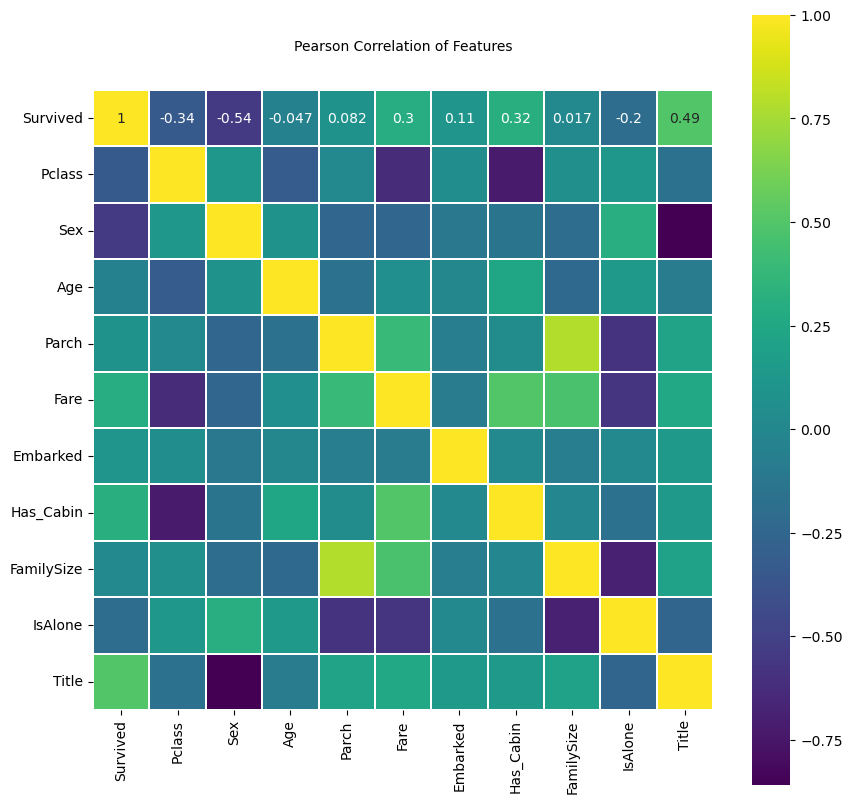

In [3]:
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', y=1.05, size=10)
sns.heatmap(train.astype(float).corr(),linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

The most correlated features with the 'Survived' survival label are:
- Title - positive correlation 0.49,
- Sex - negative correlation -0.54.

The most correlated features are:
- Title and Sex - negative correlation -0.86,
- Has_Cabin and Pclass negative correlation -0.73.

#### 1.3 Determination of survival rates for each of five different Titles using the training set.

In [4]:
titles = {
    1: 'Mr',
    2: 'Master',
    3: 'Mrs',
    4: 'Miss',
    5: 'Rare'
}

grouping = train.groupby(by=['Title'])['Survived'].mean()
grouping.index = titles.values()
grouping

Mr        0.156673
Master    0.575000
Mrs       0.793651
Miss      0.702703
Rare      0.347826
Name: Survived, dtype: float64

The highest survival rate of 0.79 was obtained for the 'Mrs' class from the training set. The lowest survival rate of 0.15 was obtained for the 'Mr' class from the training set. During the evacuation of the Titanic, married women had a greater chance of survival, which is confirmed by these results.

#### 1.4 Determining the best depth of the decision tree (gini or entropy partition criterion) using the training set and cross-validation (10-fold).

In [5]:
x, y = train.iloc[:, 1:], train.iloc[:, 0]

In [6]:
search = GridSearchCV(
    DecisionTreeClassifier(),
    {
        'criterion': ['entropy'],
        'max_depth': np.arange(1, 15)
    },
    cv = 10,
    scoring='accuracy'
)

search.fit(x, y)
print(search.best_estimator_.max_depth)

3


The best decision tree depth obtained is 3.

#### 1.5 Building a decision tree using the previously determined maximum depth (gini or entropy partition criterion).

In [7]:
decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
decision_tree.fit(x, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

#### 1.6 Prediction of the survival possibility of passengers from the test set and saving the results in a file.

In [8]:
y_pred = decision_tree.predict(x)
survival_predictions = pd.DataFrame({'PredSurvived': y_pred})
survival_predictions.to_csv('survival_predictions.csv', index=False)

#### 1.7 Decision tree visualization.

In [9]:
class_names_mapping = {0: 'Died', 1: 'Survived'}
class_names = [class_names_mapping[label] for label in [0, 1]]

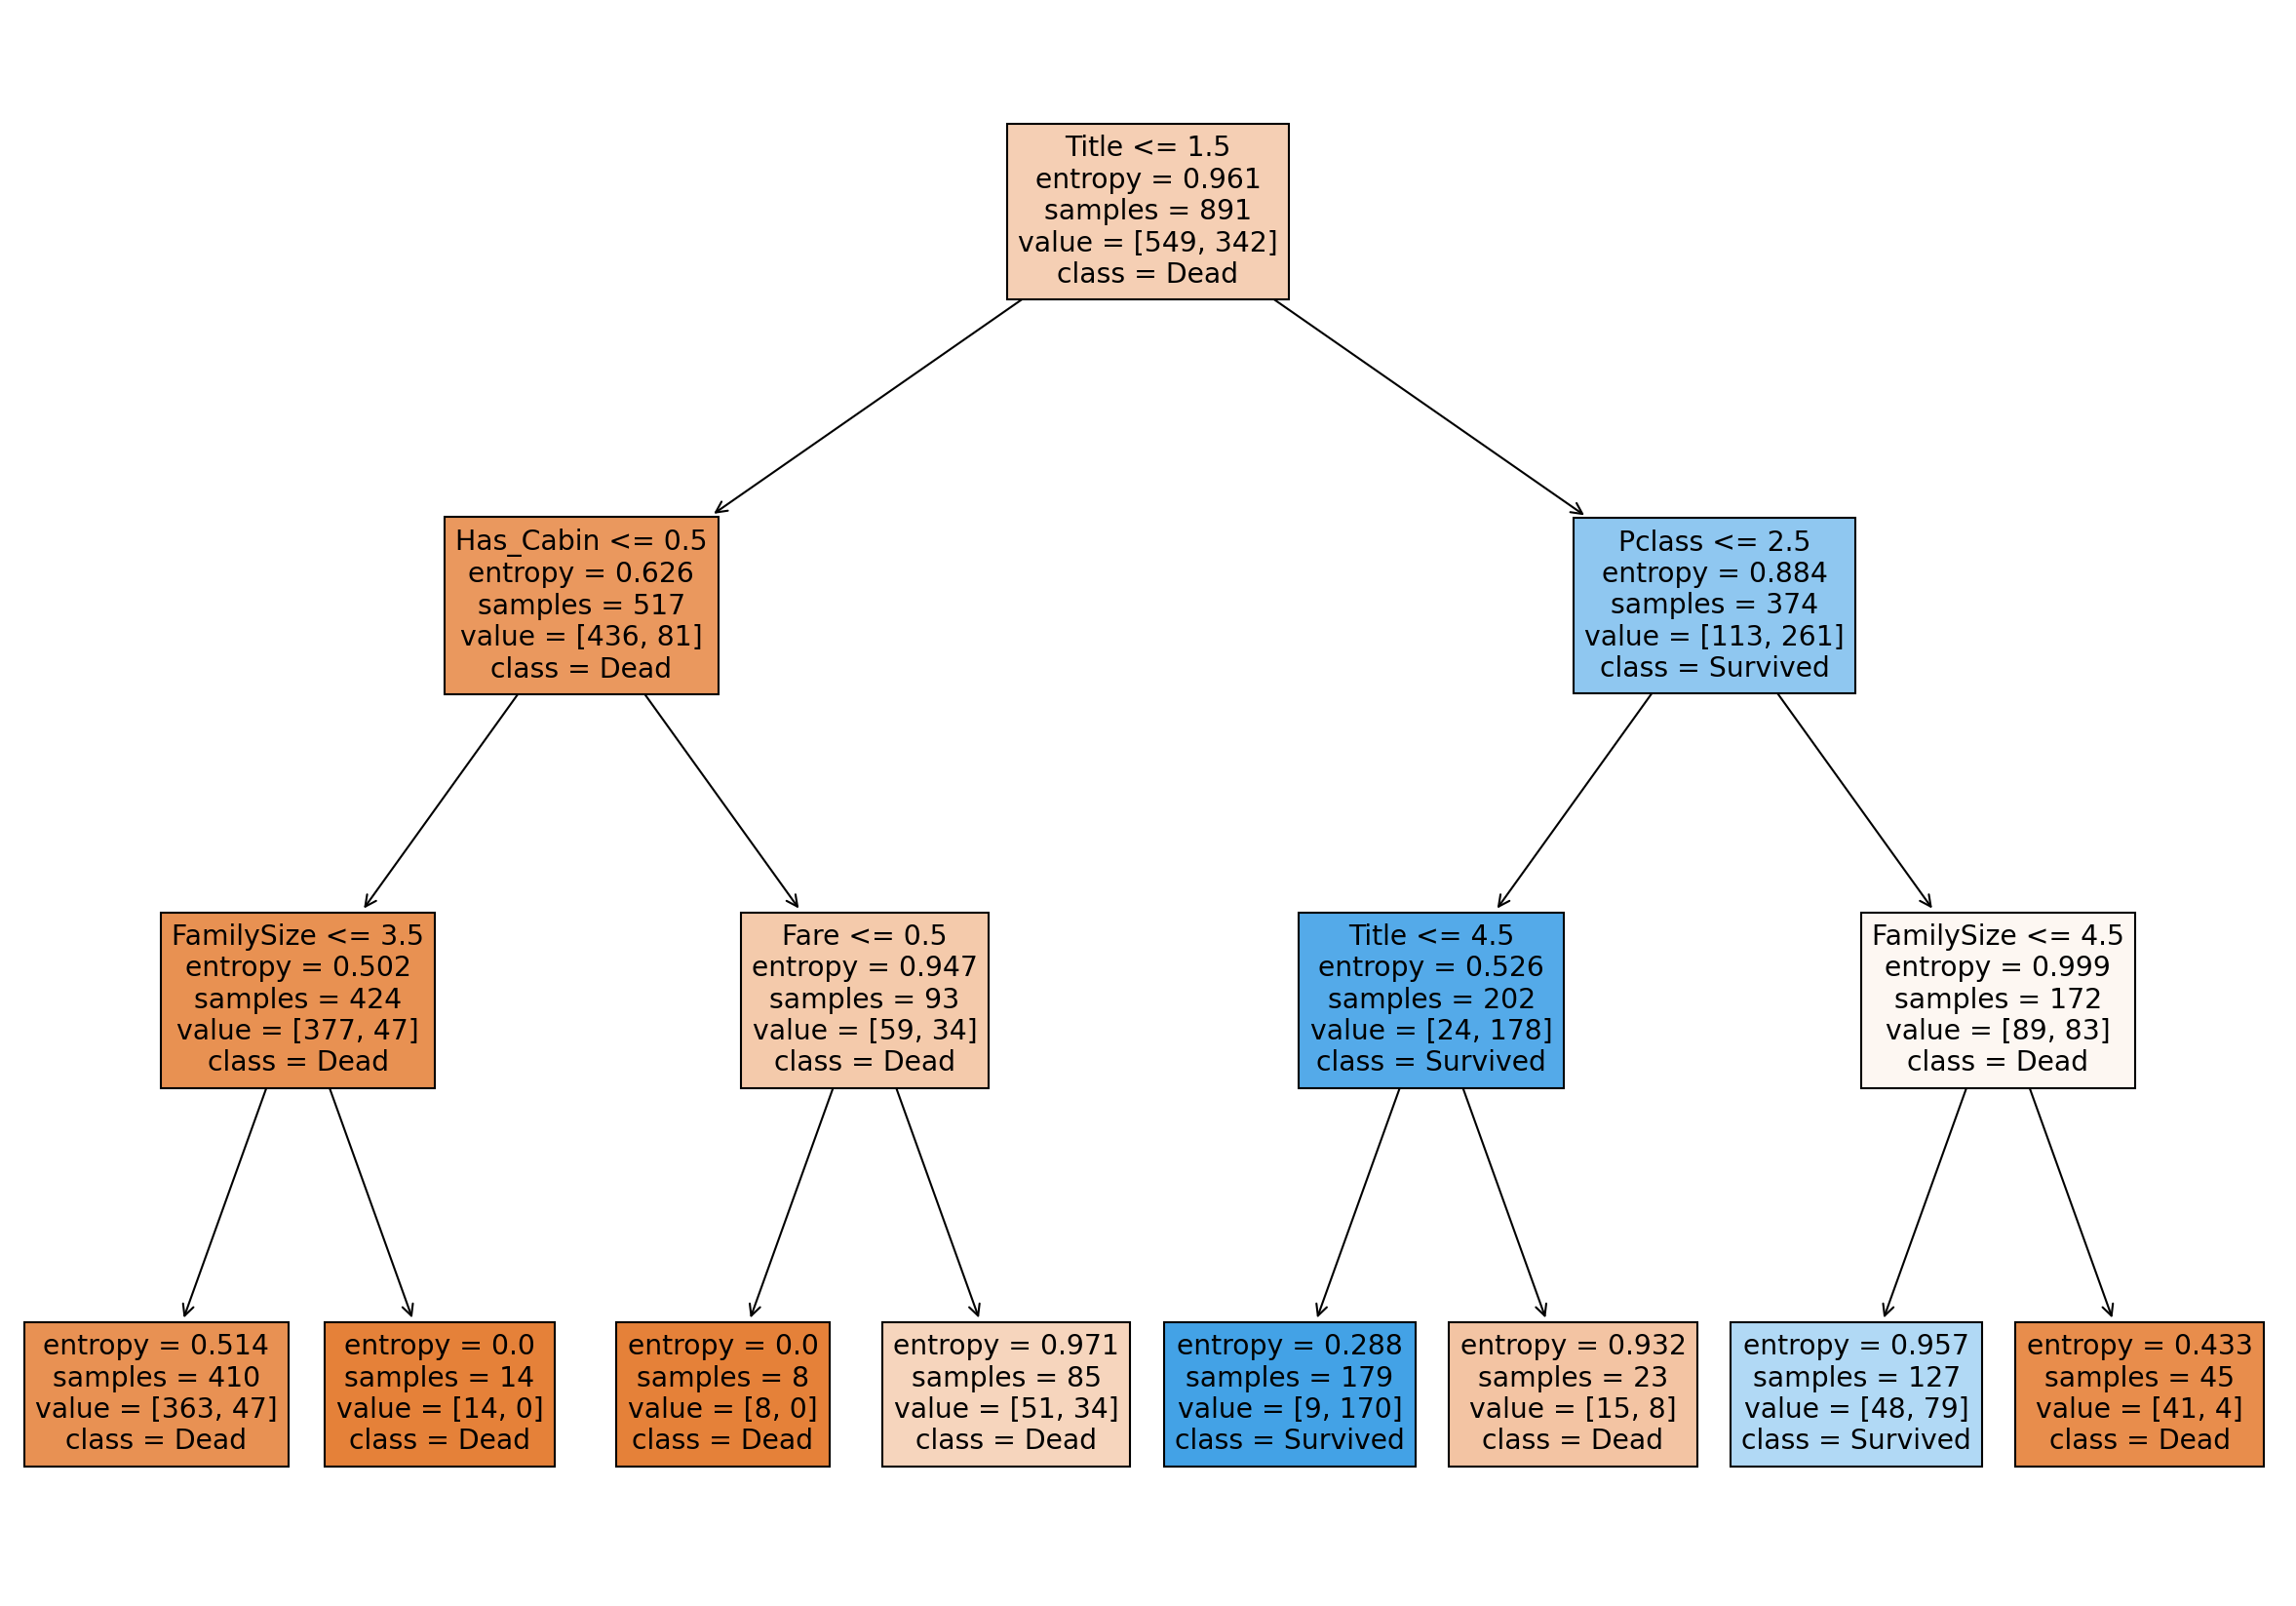

In [10]:
plt.figure(figsize=(20, 14))
plot_tree(decision_tree, feature_names=list(x.columns), class_names=['Dead', 'Survived'], filled=True)
plt.gcf().set_dpi(150)
plt.show()

#### 1.8 Checking how the classification accuracy is influenced by tree parameters: division criterion (gini vs. entropy), the smallest number of records in a leaf and the maximum tree depth.

In [11]:
def plot_search(data, target, estimator):
    search = GridSearchCV(
        estimator, 
        {'criterion': ['gini', 'entropy'],
        'max_depth': [i for i in range(2, 100, 5)],
        'min_samples_leaf': [i for i in range(1, 31)]},
        cv=10,
        scoring='accuracy'
    )
    
    search.fit(data, target)
    
    y_gini = search.cv_results_['param_max_depth'].data[search.cv_results_['param_criterion'] == 'gini']
    x_gini = search.cv_results_['param_min_samples_leaf'].data[search.cv_results_['param_criterion'] == 'gini']
    z_gini = search.cv_results_['mean_test_score'][search.cv_results_['param_criterion'] == 'gini']
    
    y_entropy = search.cv_results_['param_max_depth'].data[search.cv_results_['param_criterion'] == 'entropy']
    x_entropy = search.cv_results_['param_min_samples_leaf'].data[search.cv_results_['param_criterion'] == 'entropy']
    z_entropy = search.cv_results_['mean_test_score'][search.cv_results_['param_criterion'] == 'entropy']
    
    Y_gini, X_gini = np.meshgrid(np.unique(x_gini), np.unique(y_gini))
    Z_gini = z_gini.reshape(X_gini.shape[0], X_gini.shape[1])
    Y_gini, X_gini, Z_gini = np.array(Y_gini, dtype=float), np.array(X_gini, dtype=float), np.array(Z_gini, dtype=float)
    
    Y_entropy, X_entropy = np.meshgrid(np.unique(x_entropy), np.unique(y_entropy))
    Z_entropy = z_entropy.reshape(X_entropy.shape[0], X_entropy.shape[1])
    Y_entropy, X_entropy, Z_entropy = np.array(Y_entropy, dtype=float), np.array(X_entropy, dtype=float), np.array(Z_entropy, dtype=float)

    fig, axs = plt.subplots(1, 2, figsize=(18, 7), subplot_kw={'projection': '3d'})

    axs[0].plot_surface(X_gini, Y_gini, Z_gini, cmap='coolwarm')
    axs[0].set_title('gini criterion')
    axs[0].set_xlabel('Max depth')
    axs[0].set_ylabel('Min samples per leaf')
    axs[0].set_zlabel('Prediction accuracy')

    axs[1].plot_surface(X_entropy, Y_entropy, Z_entropy, cmap='coolwarm')
    axs[1].set_title('entropy criterion')
    axs[1].set_xlabel('Max depth')
    axs[1].set_ylabel('Min samples per leaf')
    axs[1].set_zlabel('Prediction accuracy')

    plt.show()

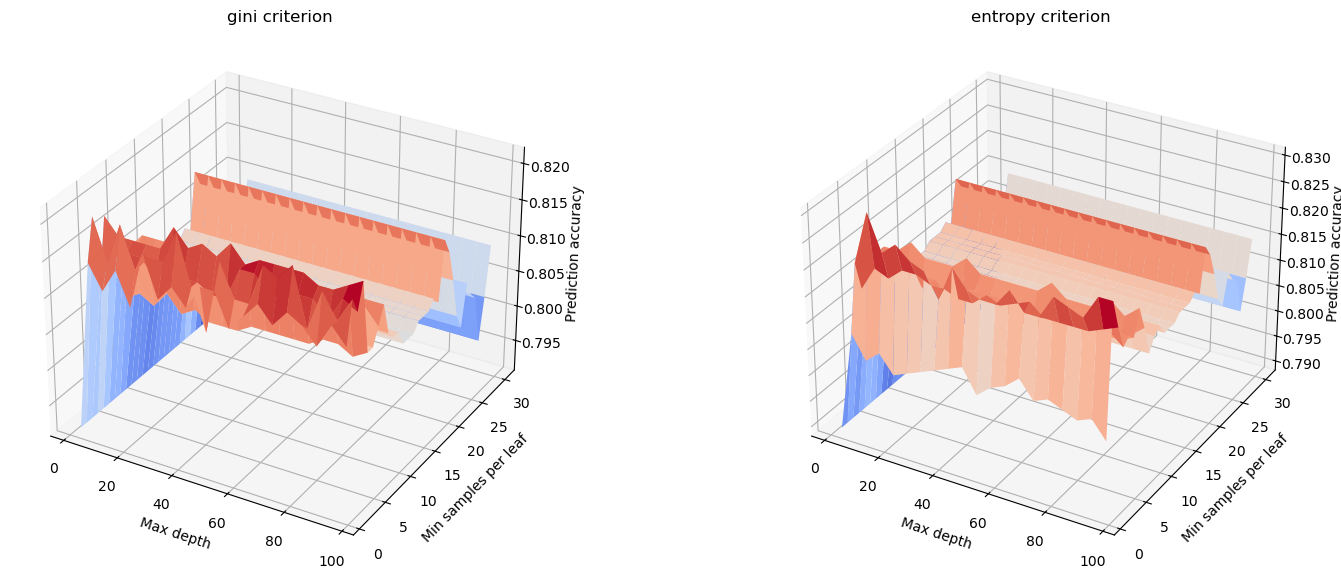

In [12]:
plot_search(x, y, DecisionTreeClassifier())

In this study, the classification accuracy obtained for the 'entropy' division criterion was slightly higher than the classification accuracy obtained for the 'gini' division criterion.

Changing the least number of records in a leaf has varying effects on classification accuracy. However, it can be noted that a small value of min_samples_leaf may lead to a more complex model for which the classification accuracy will be higher.

Changing the maximum tree depth has varying effects on classification accuracy. However, it can be seen that increasing the max_depth value can lead to an increase in classification accuracy up to a point.

#### 1.9 Splitting the training set (for which labels are available) into a new training set (75%) and a new test set (25%).

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, train_size=0.75, random_state=2)

In [14]:
y_pred = decision_tree.predict(x_test)

#### 1.10 Determination and visualization of the confusion matrix.

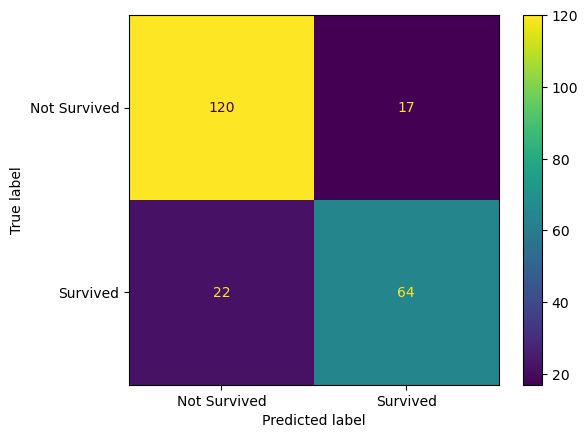

In [15]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['Not Survived', 'Survived']).plot()
plt.show()

The model confuses both classes with approximately the same frequency (false-positive: 17, false-negative: 22).

#### 1.11 Determining the quality measure of the built classifier using: accuracy, f1-score and average precision-recall.

In [16]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

average_precision = average_precision_score(y_test, y_pred)
print("Average Precision-Recall:", average_precision)

Accuracy: 0.8251121076233184
F1-score: 0.7664670658682634
Average Precision-Recall: 0.6866535600849224


### 2. k-NN classifier

#### 2.1 Loading the Breast Cancer and NYT dataset.

Loading the Breast Cancer dataset.

In [2]:
breast_cancer_data = load_breast_cancer()
x_breast_cancer = breast_cancer_data.data
y_breast_cancer = breast_cancer_data.target

Loading the NYT dataset.

In [3]:
nyt_data = pd.read_csv('./nyt-frame.csv', header = 0)
x_nyt_data = nyt_data.iloc[:, 9:]
x_nyt_array = x_nyt_data.values

#### 2.2 Dimensionality reduction to 10 using PCA.

In [4]:
pca = PCA(n_components = 10, svd_solver='arpack')
x_breast_cancer_pca = pca.fit_transform(x_breast_cancer)
x_nyt_array_pca = pca.fit_transform(x_nyt_array)

#### 2.3 Measuring classification accuracy for k = 1, k = 3, k = 5, k = 7 using ten-fold cross-validation. Investigating the impact of introducing distance weights and another distance measure (Euclidean vs. Taxi) on the classification results.

In [5]:
def plot_search_2(data, target, estimator):
    accuracies, params = [], []

    search_2 = GridSearchCV(
        estimator,
        {'n_neighbors': [i for i in range(1, 8, 2)],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']},
        cv=10,
        scoring='accuracy'
    )

    search_2.fit(data, target)
    accuracies = np.array(search_2.cv_results_['mean_test_score'])
    params = np.array(list(map(lambda k: [0 if k['metric'] == 'euclidean' else 1, 0 if k['weights'] == 'uniform' else 1,
                                k['n_neighbors']], search_2.cv_results_['params'])))

    fig = plt.figure(figsize=(18, 7))
    points = fig.add_subplot(111, projection='3d')
    points.scatter(params[:, 0], params[:, 1], params[:, 2], c = accuracies, cmap = 'coolwarm', s = 70)
    points.set_xlabel('Metric (0=euclidean, 1=manhattan)'),
    points.set_ylabel('Weights (0=uniform, 1=dystans)')
    points.set_zlabel('N neighbors')
    points.set_title('An impact of parameters on classification accuracy.')

    cbar = plt.colorbar(points.collections[0], ax=points, orientation='vertical')
    cbar.set_label('Classification accuracy')
    plt.show()

##### 2.3.1 Breast Cancer Dataset

Division of data into training and testing sets.

In [6]:
x_breast_cancer_train, x_breast_cancer_test, y_breast_cancer_train, y_breast_cancer_test = train_test_split(x_breast_cancer_pca,
    y_breast_cancer, stratify=y_breast_cancer, train_size=0.75, random_state=0)

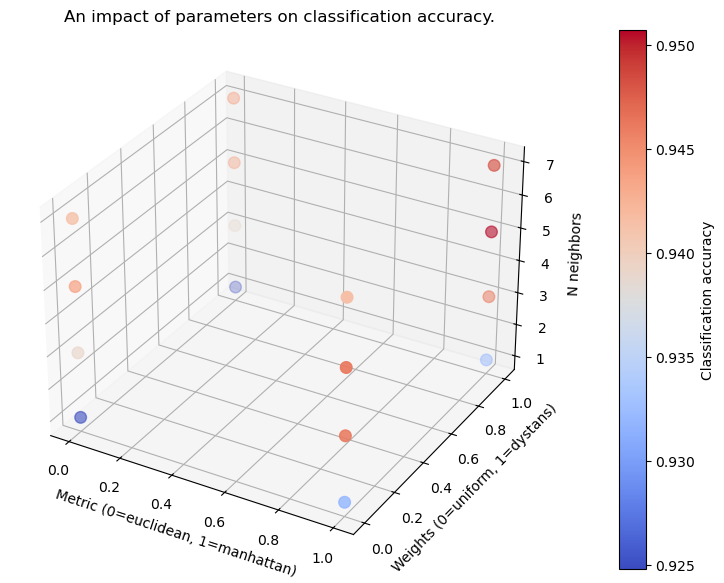

In [7]:
plot_search_2(x_breast_cancer_train, y_breast_cancer_train, KNeighborsClassifier())

The results show that for this data set, as the k value increases, the classification accuracy will increase up to a certain point.

The obtained results show that for these data, the Manhattan (Taxi) distance measure achieved better classification accuracy compared to the classification accuracy obtained for the Euclidean distance measure.

The results indicate that for both types of weights the classification accuracies are similar.

##### 2.3.2 NYT Dataset

Division of data into training and testing sets.

In [8]:
x_nyt, y_nyt = x_nyt_array_pca, nyt_data.iloc[:, 1]
x_nyt_train, x_nyt_test, y_nyt_train, y_nyt_test = train_test_split(x_nyt, y_nyt, stratify=y_nyt, train_size=0.75, random_state=0)

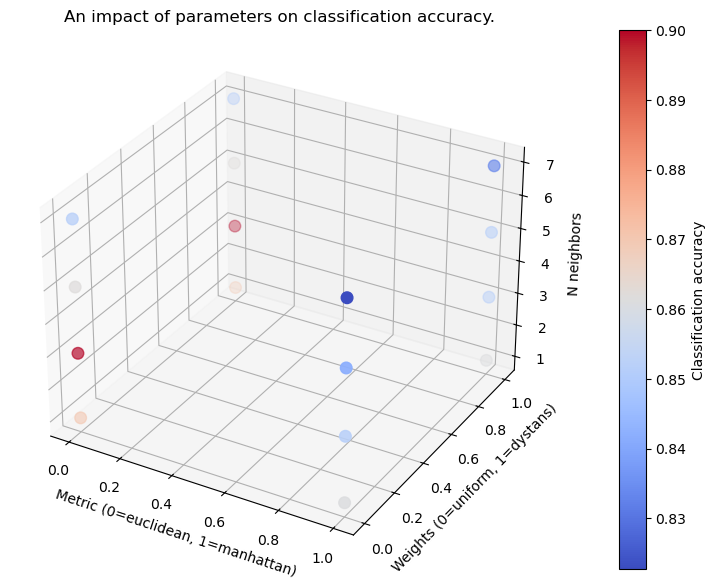

In [9]:
plot_search_2(x_nyt, y_nyt, KNeighborsClassifier())

The results show that for this data set, as the k value increased, the classification accuracy decreased.

The obtained results show that for these data the Euclidean distance measure achieved better classification accuracy compared to the classification accuracy obtained for the manhattan (Taxi) distance measure.

The results indicate that for both types of weights the classification accuracies are similar.

#### 2.4 Implementation and testing of the KD-tree algorithm for n dimensions.

Implementation of the KD-tree algorithm.

In [23]:
class Node:
    def __init__(self, location=None, left=None, right=None):
        self.location = location
        self.left = left
        self.right = right

def get_median(list_of_points, axis):
    sorted_points = sorted(list_of_points, key=lambda x: x[axis])
    median_index = len(sorted_points) // 2
    return sorted_points[median_index], median_index

def kdtree(list_of_points, depth):
    if len(list_of_points) == 0:
        return None

    k = len(list_of_points[0])
    axis = depth % k
    median, median_index = get_median(list_of_points, axis)

    list_of_points.sort(key=lambda x: x[axis])
    
    left_child = kdtree(list_of_points[:median_index], depth + 1)
    right_child = kdtree(list_of_points[median_index + 1:], depth + 1)
    node = Node(median, left_child, right_child)

    return node

Testing the KD-tree algorithm on a simple example of a tree and a list of point coordinates [(1, 9), (2, 3), (4, 1), (3, 7), (5, 4), (6, 8), (7, 2), (8, 8), (7, 9), (9, 6)].

In [24]:
points = [(1, 9), (2, 3), (4, 1), (3, 7), (5, 4), (6, 8), (7, 2), (8, 8), (7, 9), (9, 6)]
tree = kdtree(points, 2)

print(f'Root: {tree.location}')
print(f'Left node: {tree.left.location}')
print(f'Right node: {tree.right.location}')

Root: (6, 8)
Left node: (5, 4)
Right node: (8, 8)


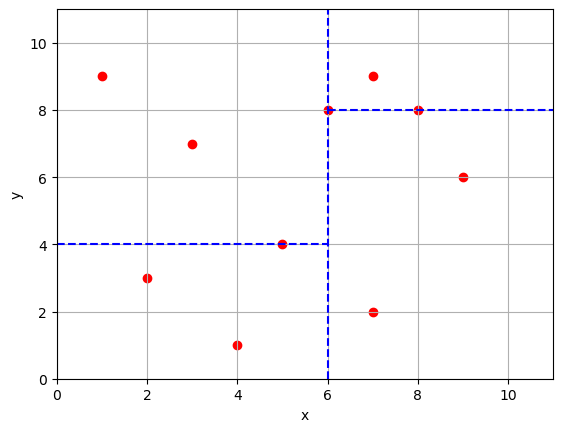

In [25]:
x_coordinates, y_coordinates = zip(*points)

plt.scatter(x_coordinates, y_coordinates, color='red')
plt.axvline(tree.location[0], color='blue', linestyle='--')
plt.axhline(y = tree.left.location[1], xmin = 0, xmax = tree.location[0]/11, color = 'blue', linestyle = '--')
plt.axhline(y = tree.right.location[1], xmin = tree.location[0]/11, xmax = 11, color = 'blue', linestyle = '--')
plt.xlim(0, 10 + 1)
plt.ylim(0, 10 + 1)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Due to the fact that the tree was only 2 levels deep, the space was divided into 4 subspaces. The points in the example are in different subspaces. The visualization shows that KD-tree enables efficient search for points in a multidimensional space.

### 3. Random forests

#### 3.1 Checking whether the use of many uncorrelated decision trees (random forest) can improve the classification results obtained in points 5.8, 5.9, 5.10 (in the report these are points 1.8, 1.9 and 1.10).

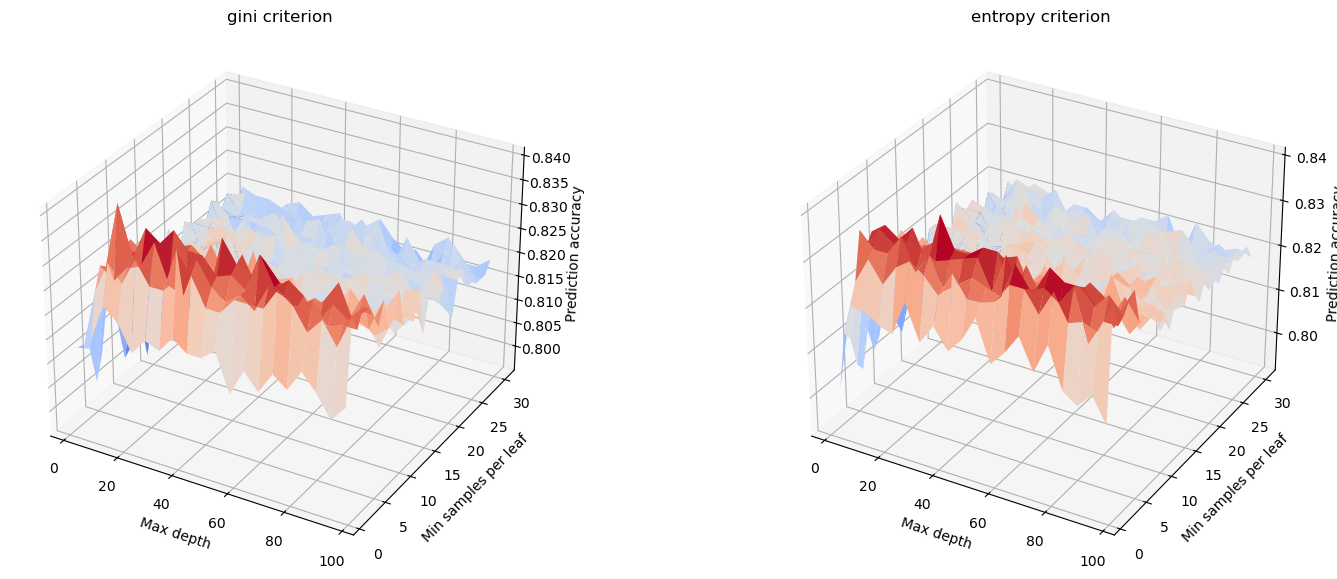

In [26]:
plot_search(x, y, RandomForestClassifier())

In this study, the classification accuracy obtained for the 'entropy' division criterion was slightly higher than the classification accuracy obtained for the 'gini' division criterion. Compared to the results of DecisionTreeClassifier, the results of RandomForestClassier are much higher.

Changing the least number of records in a leaf has varying effects on classification accuracy. However, it can be noted that a small value of min_samples_leaf may lead to a more complex model for which the classification accuracy will be higher. Compared to the results of DecisionTreeClassifier, the results of RandomForestClassifier are much higher.

Changing the maximum tree depth has varying effects on classification accuracy. However, it can be seen that increasing the max_depth value can lead to an increase in classification accuracy up to a point. Compared to the results of DecisionTreeClassifier, the results of RandomForestClassifier are much higher.

**Split the training set.**

The division of the training set (for which labels are available) into a new training set (75%) and a new test set (25%) was carried out in subsection 1.9 (equivalent to section 5.9 in the command).

**Determination and visualization of the confusion matrix.**

In [27]:
random_forest = RandomForestClassifier(max_depth=3)
random_forest.fit(x_train, y_train)

RandomForestClassifier(max_depth=3)

In [28]:
y_pred = random_forest.predict(x_test)

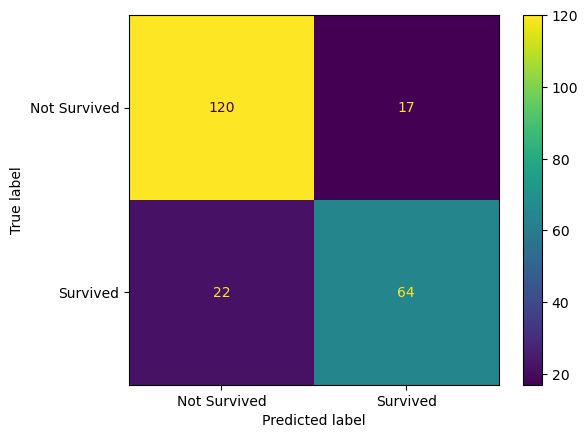

In [29]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['Not Survived', 'Survived']).plot()
plt.show()

The model confuses both classes with approximately the same frequency (false-positive: 17, false-negative: 22).

#### 3.2 Testing the classification accuracy obtained using the RandomForest classifier on the Breast Caner set (results of ten-fold cross-validation). What model parameter values gave the best results? Does the use of PCA significantly affect the results achieved?

##### 3.2.1 Using PCA.

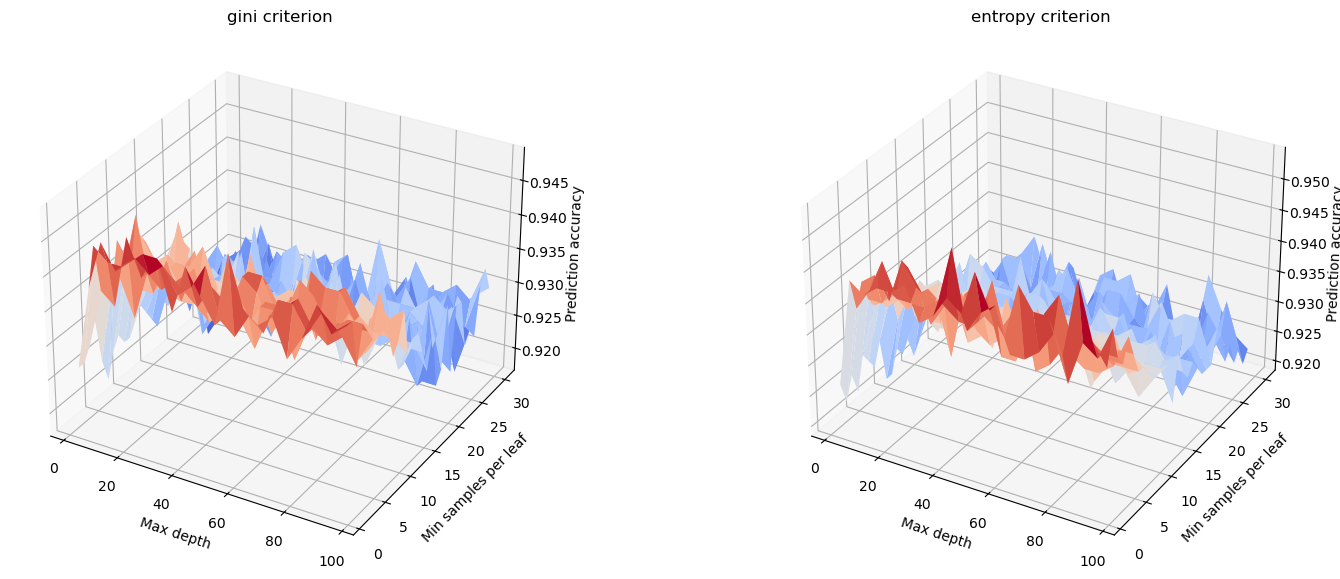

In [30]:
plot_search(x_breast_cancer_pca, y_breast_cancer, RandomForestClassifier())

In this study, the classification accuracy obtained for the 'entropy' division criterion was slightly higher than the classification accuracy obtained for the 'gini' division criterion.

Changing the least number of records in a leaf has varying effects on classification accuracy. However, it can be noted that a small value of min_samples_leaf may lead to a more complex model for which the classification accuracy will be higher. Analyzing the graphs, it can be seen that the highest classification accuracy values were achieved for min_samples_leaf in the range from 1 to 5.

Changing the maximum tree depth has varying effects on classification accuracy. However, it can be seen that increasing the max_depth value can lead to an increase in classification accuracy up to a point. Analyzing the graphs, it can be seen that the highest classification accuracy values were achieved for max_depth in the range from 60 to 80.

##### 3.2.2 Without using PCA.

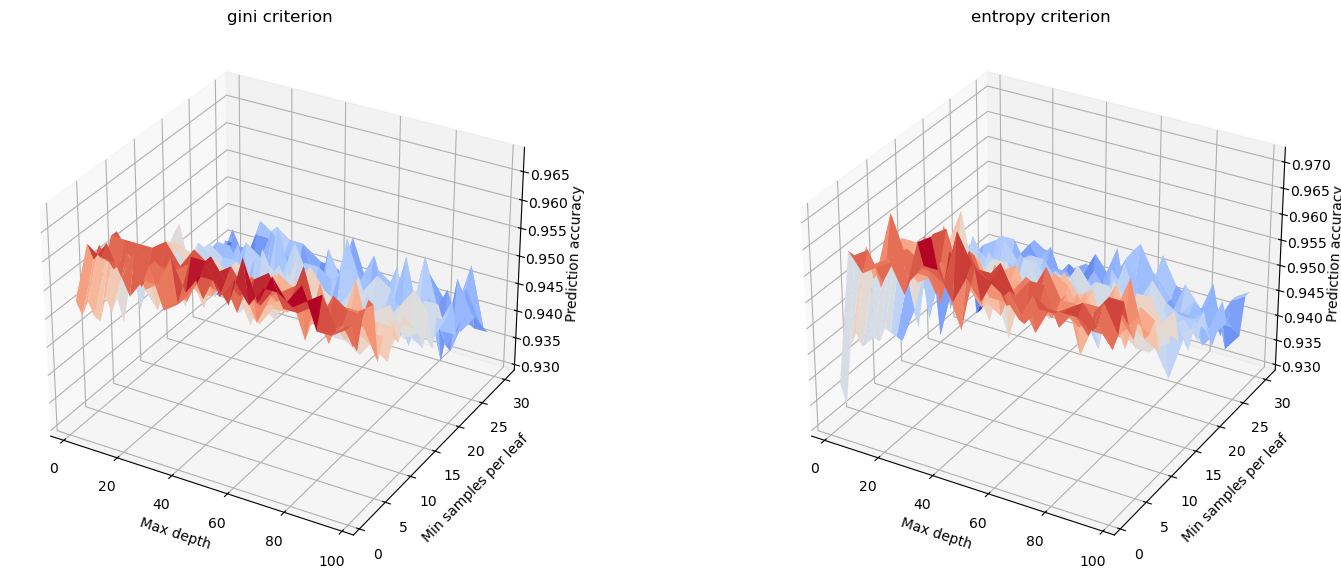

In [32]:
plot_search(x_breast_cancer, y_breast_cancer, RandomForestClassifier())

Comparing the graphs obtained using PCA and without PCA, it can be seen that the classification accuracies are higher for data where PCA was not used. The differences (visible from the second decimal place) in the results obtained with and without PCA allow us to conclude that the use of PCA does not significantly affect the results.

In this study, the classification accuracy obtained for the 'entropy' division criterion was slightly higher than the classification accuracy obtained for the 'gini' division criterion.

Changing the least number of records in a leaf has varying effects on classification accuracy. However, it can be noted that a small value of min_samples_leaf may lead to a more complex model for which the classification accuracy will be higher. Analyzing the graphs, it can be seen that the highest classification accuracy values were achieved for min_samples_leaf in the range from 1 to 5.

Changing the maximum tree depth has varying effects on classification accuracy. However, it can be seen that increasing the max_depth value can lead to an increase in classification accuracy up to a point. Analyzing the graphs, it can be seen that the highest classification accuracy values were achieved for max_depth in the range from 60 to 80.